The code for importing the essential libraries.

In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import cv2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

import h5py

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [3]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

**Loading the dataset**

In [4]:
test_ratio = 0.7
windowSize = 25

In [5]:
x = sio.loadmat('../input/cuprite/CupriteS1_R188.mat')
Y = sio.loadmat('../input/cuprite-gt/groundTruth_Cuprite_nEnd12.mat')
Y

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Oct 22 22:27:15 2014',
 '__version__': '1.0',
 '__globals__': [],
 'waveLength': array([[0.39992001, 0.40975   , 0.41957999, 0.42941   , 0.43923001,
         0.44906   , 0.45889001, 0.46870999, 0.47854001, 0.48837   ,
         0.49819   , 0.50801999, 0.51784003, 0.52766998, 0.53748999,
         0.54732001, 0.55714001, 0.56696002, 0.57678998, 0.58660999,
         0.59642999, 0.60625   , 0.61608002, 0.62590002, 0.63571997,
         0.64553998, 0.65535999, 0.66517999, 0.675     , 0.65416998,
         0.66371002, 0.67325   , 0.68278998, 0.69233002, 0.70187   ,
         0.71140997, 0.72095001, 0.73048999, 0.74003003, 0.74957001,
         0.75912   , 0.76865997, 0.77820001, 0.78775   , 0.79728998,
         0.80684003, 0.81639001, 0.82592999, 0.83547998, 0.84503003,
         0.85458002, 0.86412   , 0.87366998, 0.88321997, 0.89277002,
         0.90233002, 0.91188   , 0.92142999, 0.93097998, 0.94634998,
         0.95576001

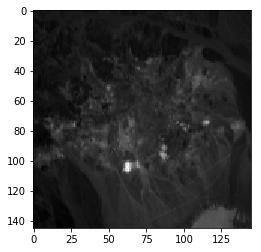

In [6]:
gt = np.zeros((250,190))
img = x['Y']  
imgshows = []
for i in range(x['Y'].shape[0]):
    imgshow = img[i,].reshape(gt.shape, order='F')
    imgshows.append(cv2.resize(imgshow,(145,145)))
mc = np.asarray(imgshows)
X = mc.T

plt.imshow(X[:,:,5],cmap = 'gray')

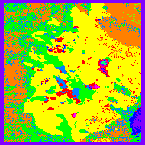

In [7]:
#final working y
y = Image.open('../input/gt-cuprite/Cuprite_S1_R188.png')
y = y.convert('RGB')
y  = y.resize((145,145))
y = y.convert("P", palette=Image.ADAPTIVE, colors=12)
y_gt = np.asarray(y)
y

In [8]:
newX = np.reshape(X, (-1, X.shape[2]))
pca = PCA(n_components=30, whiten=True)
newX = pca.fit_transform(newX)
newX = np.reshape(newX, (X.shape[0],X.shape[1], 30))
X = newX

X.shape

(145, 145, 30)

In [9]:
X, y = createImageCubes(X, y_gt, windowSize=windowSize)

X.shape, y.shape

((21025, 25, 25, 30), (21025,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6307, 25, 25, 30), (14718, 25, 25, 30), (6307,), (14718,))

In [11]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.333)

#X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

**Training the model**

In [12]:
X_train = X_train.reshape(-1, windowSize, windowSize, 30, 1)
X_train.shape

(6307, 25, 25, 30, 1)

In [13]:
y_train = np_utils.to_categorical(y_train)
y_train.shape

(6307, 11)

In [14]:
# X_valid = X_valid.reshape(-1, windowSize, windowSize, K, 1) X_valid.shape
# y_valid = np_utils.to_categorical(y_valid) 
# y_valid.shape

In [15]:
S = windowSize
L = 30
output_units = 11

In [16]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [17]:
model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

In [19]:
#Compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
'''# checkpoint
filepath = 'best-model.hdf'
f = h5py.File(filepath)
checkpoint = ModelCheckpoint('/kaggle/working/best-model.hdf', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#f.create_dataset('dataset', data= checkpoint)
print(f.keys())'''

"# checkpoint\nfilepath = 'best-model.hdf'\nf = h5py.File(filepath)\ncheckpoint = ModelCheckpoint('/kaggle/working/best-model.hdf', monitor='val_acc', verbose=1, save_best_only=True, mode='max')\ncallbacks_list = [checkpoint]\n#f.create_dataset('dataset', data= checkpoint)\nprint(f.keys())"

In [21]:
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=50)

Epoch 1/50
6307/6307 [==============================] - 264s 42ms/step - loss: 1.8105 - accuracy: 0.3472
Epoch 2/50
6307/6307 [==============================] - 262s 42ms/step - loss: 1.4096 - accuracy: 0.4947
Epoch 3/50
6307/6307 [==============================] - 262s 42ms/step - loss: 1.1827 - accuracy: 0.5979
Epoch 4/50
6307/6307 [==============================] - 262s 42ms/step - loss: 0.9540 - accuracy: 0.6816
Epoch 5/50
6307/6307 [==============================] - 263s 42ms/step - loss: 0.8550 - accuracy: 0.7084
Epoch 6/50
6307/6307 [==============================] - 263s 42ms/step - loss: 0.8006 - accuracy: 0.7225
Epoch 7/50
6307/6307 [==============================] - 263s 42ms/step - loss: 0.7365 - accuracy: 0.7428
Epoch 8/50
6307/6307 [==============================] - 263s 42ms/step - loss: 0.6948 - accuracy: 0.7479
Epoch 9/50
6307/6307 [==============================] - 263s 42ms/step - loss: 0.6650 - accuracy: 0.7645
Epoch 10/50
6307/6307 [==============================] 

In [22]:
history_dict = history.history.keys()
print(history_dict)

dict_keys(['loss', 'accuracy'])


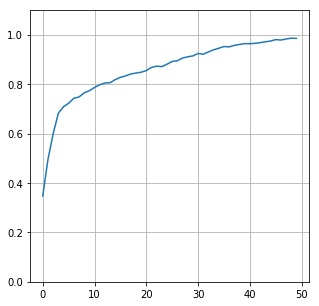

In [25]:
xc = range(50)
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(xc,history.history['accuracy'])


**Validation**

In [ ]:
'''model.load_weights("/kaggle/working/best-model.hdf")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])'''

In [26]:
X_test = X_test.reshape(-1, windowSize, windowSize, 30, 1)
X_test.shape

(14718, 25, 25, 30, 1)

In [27]:
y_test = np_utils.to_categorical(y_test)
y_test.shape

(14718, 11)

In [28]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5640
           1       0.10      0.03      0.05        33
           2       0.75      0.82      0.78        11
           3       0.66      0.68      0.67      3049
           4       0.69      0.76      0.72      2711
           5       0.71      0.28      0.40        18
           6       0.41      0.43      0.42        35
           7       0.43      0.40      0.41       485
           8       0.34      0.27      0.30      1144
           9       0.99      0.97      0.98      1464
          10       0.54      0.56      0.55       128

    accuracy                           0.76     14718
   macro avg       0.59      0.55      0.56     14718
weighted avg       0.75      0.76      0.75     14718



In [29]:
unique, counts = np.unique(y_gt, return_counts=True)
list(zip(unique, counts))


[(0, 8053),
 (1, 43),
 (2, 16),
 (3, 4399),
 (4, 3871),
 (5, 23),
 (6, 52),
 (7, 683),
 (8, 1600),
 (9, 2108),
 (10, 177)]

In [31]:
#np.unique(y_gt)
y_gt2 = y_gt.copy()
y_gt2 = y_gt2.astype('float64')
y_gt2[y_gt2 ==0] = 1.63
y_gt2[y_gt2 ==3] = 34.48
y_gt2[y_gt2 ==4] = 33.2
y_gt2[y_gt2 ==8] = 1.43
y_gt2[y_gt2 ==9] = 1.19
y_gt2[y_gt2 ==7] = 1.449
y_gt2[y_gt2 ==10] = 1.63
y_gt2[y_gt2 ==1] = 29.7
y_gt2[y_gt2 ==5] = 33.2
y_gt2[y_gt2 ==2] = 35.9
y_gt2[y_gt2 ==11] = 2.57
y_gt2[y_gt2 ==6] = 36.2
y_gt2


array([[1.19, 1.19, 1.19, ..., 1.19, 1.19, 1.19],
       [1.19, 1.19, 1.19, ..., 1.19, 1.19, 1.19],
       [1.19, 1.19, 1.19, ..., 1.19, 1.19, 1.19],
       ...,
       [1.19, 1.19, 1.19, ..., 1.19, 1.19, 1.19],
       [1.19, 1.19, 1.19, ..., 1.19, 1.19, 1.19],
       [1.19, 1.19, 1.19, ..., 1.19, 1.19, 1.19]])

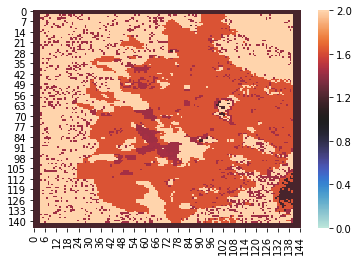

In [32]:
import seaborn as sns
ax = sns.heatmap(y_gt2,vmin=0, vmax=2,center=1)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


In [ ]:
y_gt2.shape